In [1]:
# Import libraries
import os

In [2]:
if os.environ.get("USE_GPU"):
    import setGPU

setGPU: Setting GPU to: 5


In [3]:
import json
import timeit
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp

# sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, f1_score
from sklearn.utils import class_weight
from sklearn.externals import joblib

/afs/cern.ch/user/m/mantydze/.conda/envs/my_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Configuration

data_base = "/home/mantydze/data" # no trailing slash

In [5]:
if os.environ.get("USE_EOS"):
    import getpass
    
    data_base = "/eos/user/m/mantydze/data" # no trailing slash
    
    #Authenticate in order to get permission for eos
    os.system("echo %s | kinit" % getpass.getpass())

········


In [6]:
# Read the dataset

filename = "{data_base}/JetHT2016_single/JetHT2016.h5".format(data_base=data_base)

dset = None

with h5py.File(filename, "r") as f:
    dset = f["JetHT2016"][:]   # All rows
        
print(dset.shape)
# dset=dset[::2]
# print(dset.shape)

(163684, 2813)


In [7]:
# Feature extraction

# Feature 2807 - Run number
# Feature 2808 - Lumisection number

#sort by run number and lumisection
dset = dset[np.lexsort((dset[:, 2808], dset[:, 2807]))]

# Features
X = dset[:, :2807] # 2807 features

# Target
y = dset[:, 2812]

In [8]:
# Class balance
def print_unique(values):
    unique, counts = np.unique(values, return_counts=True)

    for cls, cnt in zip(unique, counts):
        print("Class [%d] Count [%d]" % (cls, cnt))
        
print_unique(y)

Class [0] Count [3041]
Class [1] Count [160643]


In [9]:
def print_split_info(X_train, y_train, X_test, y_test):
    
    # Train class balance
    unique, counts = np.unique(y_train, return_counts=True)
    train_balance = {int(k): v for k, v in zip(unique, counts)}
    
    # Test class balance
    unique, counts = np.unique(y_test, return_counts=True)
    test_balance = {int(k): v for k, v in zip(unique, counts)}
    
    # Train class weights
    classes = np.unique(y_train)
    weights = class_weight.compute_class_weight('balanced', classes, y_train)
    cw = {int(k): round(v, 2) for k, v in zip(classes, weights)}
    
    print("Train: size %d\t balance %s\t weights %s" % (len(X_train), train_balance, cw))
    print("Test : size %d\t balance %s" % (len(X_test), test_balance))

### Import model related libraries

In [10]:
# Boosted trees classifier
from xgboost import XGBClassifier

### Train

In [11]:
def train(X_train, y_train, verbose=True, **options):
    """ Returns trained model
    """
    start_time = timeit.default_timer()
    
    # Calculate class weights of Training set
    classes = np.unique(y_train)
    weights = class_weight.compute_class_weight('balanced', classes, y_train)
    cw = {int(cls): weight for cls, weight in zip(classes, weights)}
    
    # Model code starts here
    ############
    
    params = {
        "max_depth": 7, 
        "n_estimators": 64, 
        "tree_method": "gpu_hist", 
        "predictor": "gpu_predictor"
    }
    
    model = XGBClassifier(**params)
    
    # Train
    model.fit(X_train, y_train)
    
    ############
    # Model code ends here
    
    elapsed = timeit.default_timer() - start_time
    if verbose:
        print("Train time: %.1f s" % (elapsed))
    return model
    

### Evaluate

In [12]:
def evaluate(model, X_test, y_test):
    
    # Accuracy and f1_score
    y_pred = model.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
        
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    accs.append(acc)
    f1s.append(f1)
    
    roc_auc = -1
    if acc < 1:

        # ROC AUC
        y_probas = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probas)
        roc_auc = auc(fpr, tpr)

        aucs.append(roc_auc)
        fprs.append(fpr)
        tprs.append(tpr)
        
    print("acc: %.3f | f1: %.3f | auc: %.3f" % (acc, f1, roc_auc))

### Train & evaluate

In [13]:
n_splits = 10

accs = []
f1s = []

fprs = []
tprs = []
aucs = []

In [14]:
%%time
for i in range(1, n_splits):
    print("Fold %d / %d" % (i, n_splits))
    
    X_train = X_test = y_train = y_test = None # Release memory
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - (1.0/n_splits)*i), shuffle=False)
    
    print_split_info(X_train, y_train, X_test, y_test)
    
    # Feature scaling
    sc = StandardScaler(copy=False)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    model = train(X_train, y_train)
    evaluate(model, X_test, y_test)
    model = None # Release memory
    print()
    

Fold 1 / 10
Train: size 16368	 balance {0: 585, 1: 15783}	 weights {0: 13.99, 1: 0.52}
Test : size 147316	 balance {0: 2456, 1: 144860}
Train time: 21.6 s


/afs/cern.ch/user/m/mantydze/.conda/envs/my_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[   534   1922]
 [   405 144455]]
acc: 0.984 | f1: 0.992 | auc: 0.881

Fold 2 / 10
Train: size 32736	 balance {0: 732, 1: 32004}	 weights {0: 22.36, 1: 0.51}
Test : size 130948	 balance {0: 2309, 1: 128639}
Train time: 28.8 s


/afs/cern.ch/user/m/mantydze/.conda/envs/my_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[   511   1798]
 [   130 128509]]
acc: 0.985 | f1: 0.993 | auc: 0.858

Fold 3 / 10
Train: size 49105	 balance {0: 740, 1: 48365}	 weights {0: 33.18, 1: 0.51}
Test : size 114579	 balance {0: 2301, 1: 112278}
Train time: 43.1 s


/afs/cern.ch/user/m/mantydze/.conda/envs/my_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[   390   1911]
 [    57 112221]]
acc: 0.983 | f1: 0.991 | auc: 0.747

Fold 4 / 10
Train: size 65473	 balance {0: 1424, 1: 64049}	 weights {0: 22.99, 1: 0.51}
Test : size 98211	 balance {0: 1617, 1: 96594}
Train time: 56.8 s


/afs/cern.ch/user/m/mantydze/.conda/envs/my_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  386  1231]
 [  206 96388]]
acc: 0.985 | f1: 0.993 | auc: 0.895

Fold 5 / 10
Train: size 81842	 balance {0: 1541, 1: 80301}	 weights {0: 26.55, 1: 0.51}
Test : size 81842	 balance {0: 1500, 1: 80342}
Train time: 67.3 s


/afs/cern.ch/user/m/mantydze/.conda/envs/my_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  220  1280]
 [  112 80230]]
acc: 0.983 | f1: 0.991 | auc: 0.954

Fold 6 / 10
Train: size 98210	 balance {0: 1652, 1: 96558}	 weights {0: 29.72, 1: 0.51}
Test : size 65474	 balance {0: 1389, 1: 64085}
Train time: 86.6 s


/afs/cern.ch/user/m/mantydze/.conda/envs/my_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  564   825]
 [  105 63980]]
acc: 0.986 | f1: 0.993 | auc: 0.901

Fold 7 / 10
Train: size 114578	 balance {0: 1772, 1: 112806}	 weights {0: 32.33, 1: 0.51}
Test : size 49106	 balance {0: 1269, 1: 47837}
Train time: 93.0 s


/afs/cern.ch/user/m/mantydze/.conda/envs/my_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  520   749]
 [   46 47791]]
acc: 0.984 | f1: 0.992 | auc: 0.950

Fold 8 / 10
Train: size 130947	 balance {0: 2380, 1: 128567}	 weights {0: 27.51, 1: 0.51}
Test : size 32737	 balance {0: 661, 1: 32076}
Train time: 109.6 s


/afs/cern.ch/user/m/mantydze/.conda/envs/my_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  496   165]
 [   50 32026]]
acc: 0.993 | f1: 0.997 | auc: 0.983

Fold 9 / 10
Train: size 147315	 balance {0: 2994, 1: 144321}	 weights {0: 24.6, 1: 0.51}
Test : size 16369	 balance {0: 47, 1: 16322}
Train time: 125.1 s


/afs/cern.ch/user/m/mantydze/.conda/envs/my_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[   39     8]
 [   62 16260]]
acc: 0.996 | f1: 0.998 | auc: 0.908

CPU times: user 10min 3s, sys: 3min 8s, total: 13min 11s
Wall time: 13min 17s


### Aggregate scores

In [15]:
d = dict(acc=np.array(accs), f1=np.array(f1s), auc=np.array(aucs))
scores = pd.DataFrame.from_dict(d, orient="index")
scores["mean"] = scores.mean(axis=1)
scores["std"] = scores.std(axis=1)

In [16]:
print(scores.transpose())

           acc        f1       auc
0     0.984204  0.992010  0.881069
1     0.985277  0.992554  0.858455
2     0.982824  0.991308  0.746731
3     0.985368  0.992601  0.895345
4     0.982992  0.991400  0.954392
5     0.985796  0.992785  0.900899
6     0.983811  0.991751  0.950203
7     0.993433  0.996655  0.982843
8     0.995724  0.997852  0.908274
mean  0.986603  0.993213  0.897579
std   0.004405  0.002233  0.064941


In [17]:
scores.to_csv("scores.csv")

### Plot ROC AUC

/afs/cern.ch/user/m/mantydze/.conda/envs/my_env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


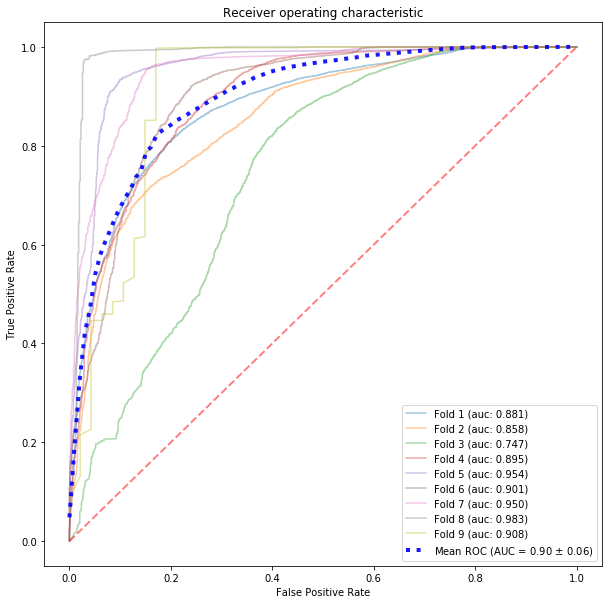

In [18]:
plt.figure(figsize=(10,10))

for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
    plt.plot(fpr, tpr, label="Fold %d (auc: %.3f)" % ((i+1), aucs[i]), alpha=0.4)

tprs2 = []

mean_fpr = np.linspace(0, 1, 100)

for fpr, tpr in zip(fprs, tprs):
    tprs2.append(interp(mean_fpr, fpr, tpr))
    
mean_tpr = np.mean(tprs2, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, 
         color="b",
         linestyle=":",
         linewidth=4,
         label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
         lw=2, alpha=.9)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.5)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Plot AUC

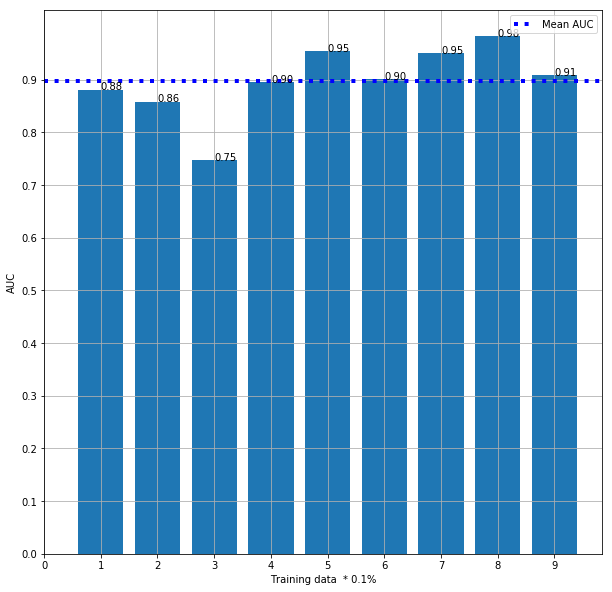

In [19]:
plt.figure(figsize=(10,10))
plt.grid()

n_bars = len(aucs) + 1

plt.axhline(y=mean_auc, color='b', linestyle=':', linewidth=4, label="Mean AUC")

xfolds = range(1, n_bars)

plt.bar(xfolds, aucs)
# add labels
for xfold, xauc in zip(xfolds, aucs):
    label = "%.2f" % xauc
    plt.text(xfold, xauc, label)

plt.yticks(np.arange(0, 1, 0.1))    
plt.xticks(np.arange(0, n_bars, 1))    
plt.xlabel("Training data  * {}%".format(round(1/n_splits, 2)))
plt.ylabel('AUC')
plt.legend(loc="upper right")
plt.show()

### Train and save model

In [20]:
X_train = X_test = y_train = y_test = None # Release memory
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [21]:
# Feature scaling
sc = StandardScaler(copy=False)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
model = train(X_train, y_train)

Train time: 113.6 s


In [23]:
evaluate(model, X_test, y_test)

/afs/cern.ch/user/m/mantydze/.conda/envs/my_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  496   165]
 [   50 32026]]
acc: 0.993 | f1: 0.997 | auc: 0.983


In [24]:
joblib.dump(model, "model.dat")

['model.dat']